# *COVID-19 Community Mobility Reports:​ Regression*

### Authors:
- Ana Mafalda Santos, up201706791
- Diogo Silva, up201706892
- João Luz, up201703782

## Introduction
---
The main purpose of this project was to build a regression model using different **Supervised Learning** algorithms for the given dataset: **CoV-19 Community Mobility Report**.

After analyzing and handling our dataset, we aim to predict the number of people infected by SARS-CoV-2 based on the variation of the population's mobility trends. To make it less biased, we'll predict the confirmed cases per million instead of using just the total amount of cases, as different countries have different population sizes.

## Description of the Problem/Dataset
---
Our dataset - **CoV-19 Community Mobility Report** - seeks to provide insights into what has changed due to policies aimed at combating COVID-19 and evaluate the changes in community activities and its relation to reduced confirmed cases of COVID-19. The reports chart movement trends, comparing to an expected baseline, over time by geography, across the following categories of places:

* **Retail & Recreation**: mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.
* **Grocery & Pharmacy**: mobility trends for places like grocery markets, food warehouses, farmers' markets, specialty food shops, drug stores, and pharmacies.
* **Parks**: mobility trends for places like national parks, public beaches, marinas, dog parks, plazas, and public gardens.
* **Transit stations**: mobility trends for places like public transport hubs such as subway, bus, and train stations.
* **Workplaces**: mobility trends for places of work.
* **Residential**: mobility trends for places of residence.

The dataset also contains these CoV-19 statistics:

* **Total Cases**: Total number of people infected with the SARS-CoV-2.
* **Fatalities**: Total number of deaths caused by CoV-19.
* **Population**: Total number of inhabitants.

## Approach
---
We start by pre-processing the data we had. To compensate for missing and NaN values on the dataset, we used Median and Zero Imputation, to better infer those missing values from the existing part of the data. We also added new columns to extract more reliable information from the existing columns:

* **New Cases (percentage)**: variation of the total cases of CoV-19 cases in comparison to the previous day.
* **New Fatalities (percentage)**: variation of the total fatalities of CoV-19 cases in comparison to the previous day.
* **Cases per Million**: total cases CoV-19 cases per million people.

In order to improve the model, several ways of partitioning the input data into training and testing data have been considered, such as Train/Test Split and K-Fold Cross-Validation.

To predict the number of people infected based on the available data, we used different algorithms for our regression model: **Support Vector Regression (SVR)**, **K-Nearest Neighbors**, **Decision Trees** and **Neural Networks (Multi-layer Perceptron)**.

At last, we tried to reduce the dimension of our dataset by using Principal Component Analysis (PCA) which combines highly correlated variables together to form a smaller number of an artificial set of variables that account for the most variance in the data.

## Experimental Evaluation
---
In this section, we will try to provide a step-by-step explanation of our approach and show the way different factors shaped our implementation along the way. 

Starting with the necessary imports:

In [37]:
import math
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate, train_test_split, KFold, cross_val_predict
from sklearn import preprocessing, linear_model, neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from matplotlib import style
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [38]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')

After reading the input file, we proceed to select and analyze its data. Since we will predict the number of cases of CoV-19 and these might depend on country-specific factors, it may be relevant to focus on a specific region in order to effectively and impartially compare the performance of the algorithms. Being one of the most affected countries in the world, the US seemed like a good candidate for this research.

In [39]:
country = 'US'
data = data.loc[(data.country == country)]
data = data.reset_index(drop=True)
# If we were taking the country column into account,
# it would intersting to take care of the Dummy Variable Trap.
# Alternatively, we chose to eliminate these columns completely.
data = data.drop(columns = ['country','iso'])
data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,population
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0,0,329064917
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0,0,329064917
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0,0,329064917
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0,0,329064917
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0,0,329064917
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0,0,329064917
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0,0,329064917
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0,0,329064917
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0,0,329064917
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0,0,329064917


Extraction of new relevant columns:

In [40]:
# Calculates daily percentual changes in number of fatalities
data['fatalities_percent_change'] = pd.Series([])

for i in range(0,len(data['fatalities'])):
    if i != 0 and data['fatalities'][i-1] != 0:
        data['fatalities_percent_change'][i]= (data['fatalities'][i] - data['fatalities'][i-1]) * 100 /data['fatalities'][i-1]
    else:data['fatalities_percent_change'][i] = 0

# Calculates daily percentual changes in number of cases
data['cases_percent_change'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if i != 0 and data['total_cases'][i-1] != 0:
        data['cases_percent_change'][i] = (data['total_cases'][i] - data['total_cases'][i-1]) * 100 /data['total_cases'][i-1]
    else:data['cases_percent_change'][i] = 0

# Calculates cases of covid per million inhabitants
data['cases_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

# Drop unnecessary columns from data set
data = data.drop(columns = ['fatalities'])
data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['population'])

data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,fatalities_percent_change,cases_percent_change,cases_per_million
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0.000000,0.000000,0.000000
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0.000000,0.000000,0.000000
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0.000000,0.000000,0.000000
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0.000000,0.000000,0.000000
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0.000000,0.000000,0.000000
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0.000000,0.000000,0.000000
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0.000000,0.000000,0.000000
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0.000000,0.000000,0.000000
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0.000000,0.000000,0.000000
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0.000000,0.000000,0.000000


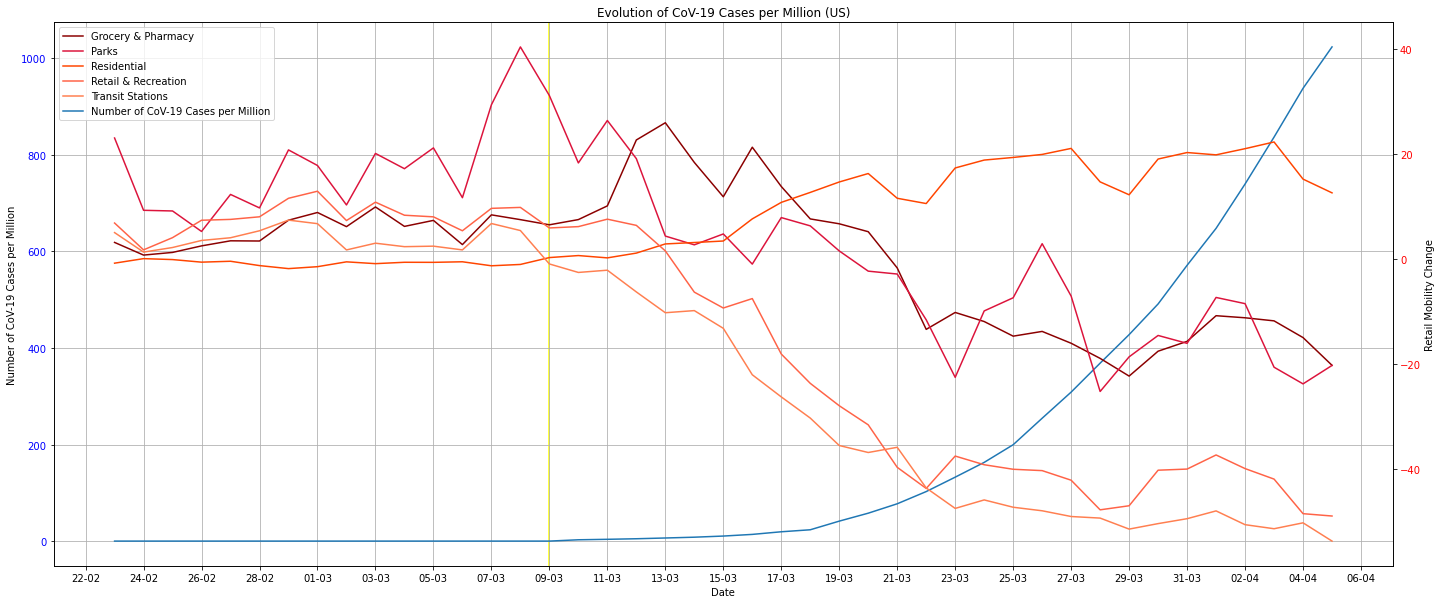

In [41]:
# We start by looking for the day of the first confirmed cases.
starting_day = pd.to_datetime(data['date'][0])
day_index = 0
for day_index in range(0,len(data['cases_per_million'])):
    if data['cases_per_million'][day_index] != 0:
        starting_day = pd.to_datetime(data['date'][day_index -1])
        break

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

# A first look at the evolution of the number of confirmed cases per million 
# and how the mobility (namely retail and recreation) was affected.
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
cases_per_million_plot, = ax.plot(date_format, data['cases_per_million'])
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.axvline(starting_day, c="yellow", zorder=0)
ax.tick_params(axis='y', labelcolor= "blue")
ax2 = ax.twinx()  
ax2.set_ylabel('Retail Mobility Change')
grocery_pharmacy, = ax2.plot(date_format, data['grocery_pharmacy'], color = "darkred")
parks, = ax2.plot(date_format, data['parks'], color = "crimson")
residential, = ax2.plot(date_format, data['residential'], color = "orangered")
retail_recreation, = ax2.plot(date_format, data['retail_recreation'], color = "tomato")
transit_stations, = ax2.plot(date_format, data['transit_stations'], color = "coral")

ax.legend((grocery_pharmacy, parks, residential, retail_recreation, transit_stations, cases_per_million_plot), ('Grocery & Pharmacy', 'Parks', 'Residential', 'Retail & Recreation', 'Transit Stations','Number of CoV-19 Cases per Million'), loc='upper left', shadow=False)

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "red")
plt.show()

As we can see from the graph above, when the first cases of CoV-19 were registered, the overall mobility dropped considerably, with exception of the residential trendline which, given the context of our dataset, increases as expected. For this reason, we will only consider data starting from this inflection point on.

That being said, we can now define the Total Number of Cases per Million as our **target variable** and isolate it from our **independent variables**. 

In [42]:
X = data.iloc[day_index:,1:9]
Y = data.iloc[day_index:,9:]
X

,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,fatalities_percent_change,cases_percent_change
16,7.467,18.240,0.625,6.129,-2.587,-1.549,0.000000,0.000000
17,10.072,26.313,0.185,7.546,-2.158,-1.159,28.571429,36.098655
18,22.608,19.057,1.093,6.366,-6.292,-2.903,11.111111,31.466227
19,25.884,4.332,2.836,1.514,-10.247,-6.855,17.500000,32.330827
20,18.339,2.665,3.105,-6.332,-9.845,-0.989,14.893617,25.852273
21,11.804,4.734,3.391,-9.351,-13.214,-6.666,16.666667,29.082017
22,21.230,-1.000,7.600,-7.559,-22.047,-19.867,34.920635,33.051588
23,13.762,7.847,10.739,-18.104,-26.256,-26.753,27.058824,39.167579
24,7.594,6.272,12.635,-23.678,-30.283,-30.611,9.259259,21.438690
25,6.668,1.505,14.618,-27.935,-35.502,-33.412,69.491525,76.383668


In [43]:
# Replaces NaN values present in the new columns by 0 (Zero Inputation)
X['fatalities_percent_change'] = X['fatalities_percent_change'].replace(np.NaN, 0)
X['cases_percent_change'] = X['cases_percent_change'].replace(np.NaN, 0)
Y['cases_per_million'] = Y['cases_per_million'].replace(np.NaN, 0)

# Fills the empty values taking mean values present in each column (Mean Inputation)
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)

Y

array([[   2.71071133],
       [   3.68924166],
       [   4.85010683],
       [   6.41818648],
       [   8.07743355],
       [  10.42651411],
       [  13.87264264],
       [  19.30622097],
       [  23.4452219 ],
       [  41.35354241],
       [  57.81533982],
       [  77.29477889],
       [ 102.60893294],
       [ 132.45410783],
       [ 163.06508907],
       [ 199.65969207],
       [ 254.53640201],
       [ 308.69288931],
       [ 368.65978028],
       [ 427.74842509],
       [ 491.32858487],
       [ 571.37054206],
       [ 647.93902049],
       [ 739.79627552],
       [ 836.99594144],
       [ 938.09149518],
       [1023.84661079]])

To prevent a feature that has a variance that is orders of magnitude larger than others, from dominating the objective function and make the estimator unable to learn from other features correctly as expected, it is wise to perform standardization of such features.

In [44]:
# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)

Once pre-processed, our data can now be divided into subsets meant for training and testing our models. Usually, it would be very convenient to make use of K-Fold Cross-Validation (recommended for big datasets), since it provides a better way of partitioning the data into the mentioned subsets, leading to greater results. Unfortunately, given the small dimension of our dataset, we were not able to obtain satisfactory enough results in order to use this method. Thus, we decided to apply Train/Test Split (80%/20%) which randomly selects the input and output data as training or testing data.

In [45]:
# Create training and testing vars
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

We are now ready to start training and testing our models.

### Support Vector Regression

We start by using the SVR algorithm, which is an extension of the Support Vector Machine algorithm, usually used in Classification models, but applied to Regression. The **scikit-learn** library provides several alternatives for kernel functions, namely **Radial Basis** (the default option according to the documentation), **Linear**, or **Polynomial**. Besides being relatively memory efficient, the SVR algorithm works well with high dimensional spaces and small datasets without too much noise. Making it a good contender for this problem.
In this section, we will be comparing the performance of these kernels to the **Ordinary Least Squares Linear Regression** (OLS). 


In [46]:
# Linear Regression Model
lm = linear_model.LinearRegression()

# Suport Vector Regression Models
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

# Fitting/Training models
model = lm.fit(X_train, Y_train)
svr_lin_model = svr_lin.fit(X_train, Y_train)
svr_rbf_model = svr_rbf.fit(X_train, Y_train)
svr_poly_model = svr_poly.fit(X_train, Y_train)

# Obtaining predictions from models
linear_predictions = lm.predict(X)
svr_lin_predictions = svr_lin_model.predict(X)
svr_rbf_predictions = svr_rbf_model.predict(X)
svr_poly_predictions = svr_poly_model.predict(X)

# Testing models
linear_score = model.score(X_test, Y_test)
svr_lin_score = svr_lin_model.score(X_test, Y_test)
svr_rbf_score = svr_rbf_model.score(X_test, Y_test)
svr_poly_score = svr_poly_model.score(X_test, Y_test)

print("Linear Regression Score:", linear_score)
print("Linear SVR Score: %s" % (svr_lin_score))
print("RBF SVR Score: %s" % (svr_rbf_score))
print("Polynomial SVR Score: %s" % (svr_poly_score))

Linear Regression Score: 0.3756860295490796
Linear SVR Score: 0.56572413789943
RBF SVR Score: 0.6789530397892976
Polynomial SVR Score: 0.8841793709604677


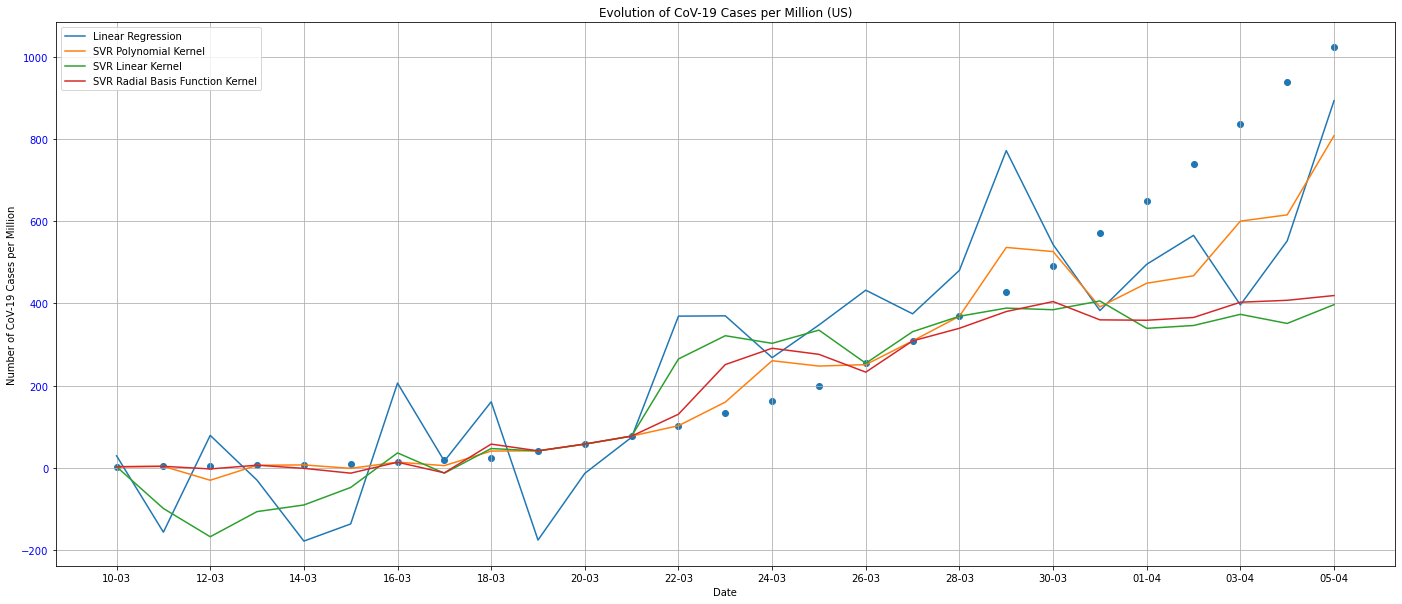

In [47]:
# Visual Comparison of the predictions obtained by different 
# parameterizations of the SVR model compared to a Linear Regression model
dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format[day_index:], data['cases_per_million'][day_index:])
linear_plot, = ax.plot(date_format[day_index:], linear_predictions)
svr_poly_plot, = ax.plot(date_format[day_index:], svr_poly_predictions)
svr_lin_plot, = ax.plot(date_format[day_index:], svr_lin_predictions)
svr_rbf_plot, = ax.plot(date_format[day_index:], svr_rbf_predictions)
ax.legend((linear_plot, svr_poly_plot, svr_lin_plot, svr_rbf_plot), ('Linear Regression', 'SVR Polynomial Kernel','SVR Linear Kernel', 'SVR Radial Basis Function Kernel'), loc='upper left', shadow=False)

ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelcolor= "blue")

As we can see by the scores obtained by the comparison of the predictions with the labeled data in several experiments, the performance of the SVR linear kernel tends to be worse or as goods as OLS, whereas the remaining kernels tend to be better for this particular dataset.

### K-Nearest Neighbor

We proceed to apply the K-Nearest Neighbor algorithm. Once again, we are given two alternatives for the weights specified for the "neighbors". Using a uniform weight distribution, each of the k-neighbor's weight is taken into account equally. On the other hand, when considering the distance between these neighbors, the weight decreases with the distance.

KNN Regression Model - Uniform:  0.70197052312614
KNN Regression Model - Distance:  0.6827051489302913


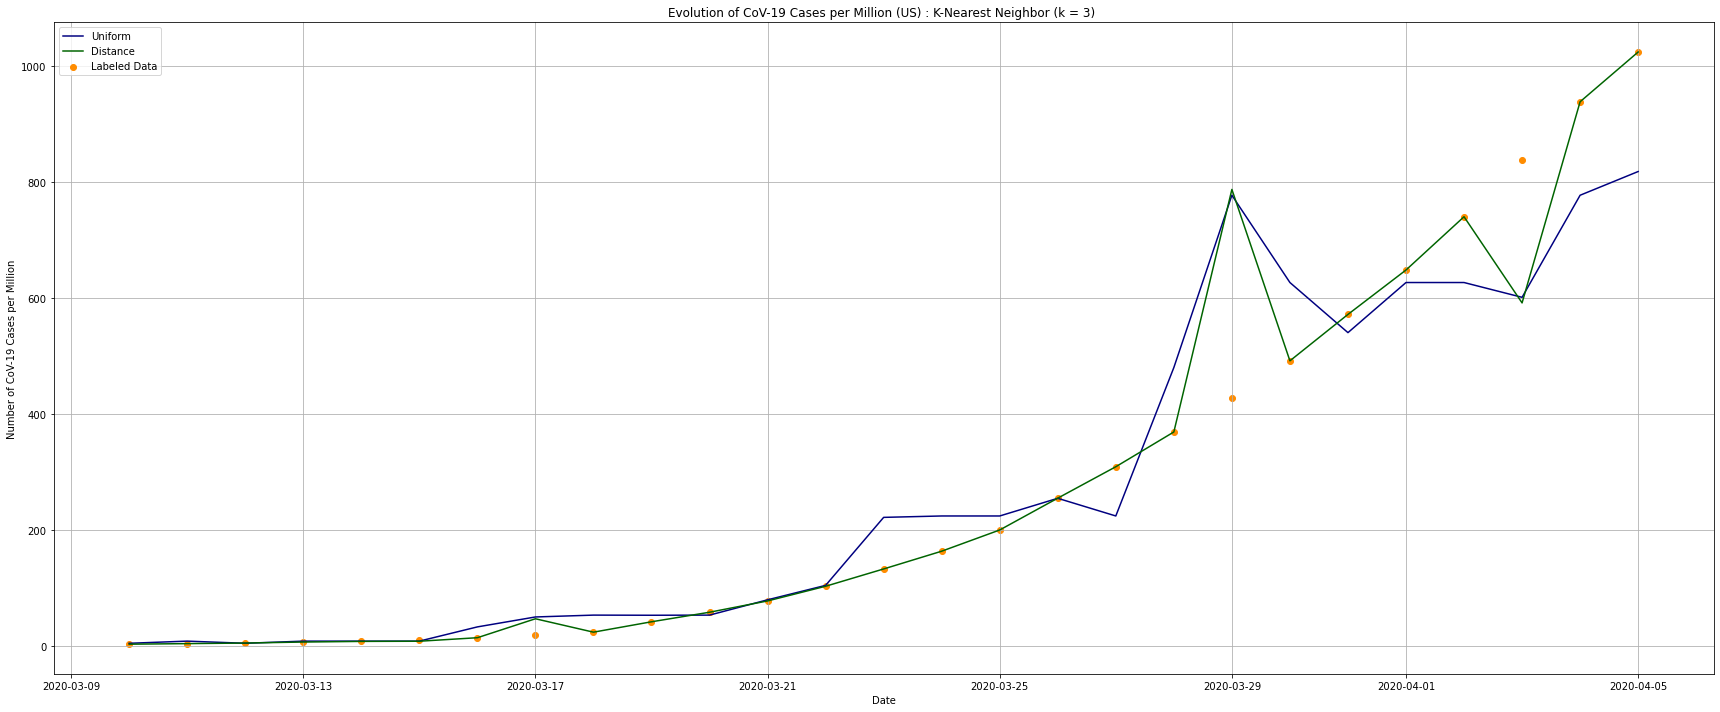

In [48]:
n_neighbors = 3
# K-Nearest Neighbor Models
knn_uniform = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn_distance = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')

# Fitting/Training and obtaining predictions from models
knn_predictions_uniform = knn_uniform.fit(X_train, Y_train).predict(X)
knn_predictions_distance = knn_distance.fit(X_train, Y_train).predict(X)

# Testing models
knn_uniform_score = knn_uniform.score(X_test, Y_test)
knn_distance_score = knn_distance.score(X_test, Y_test)

print("KNN Regression Model - Uniform:  %s"  % (knn_uniform_score))
print("KNN Regression Model - Distance:  %s"  % (knn_distance_score))

# Visual Comparison of the predictions obtained by different 
# parameterizations of the KNN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
unif, = ax.plot(date_format[day_index:], knn_predictions_uniform, color='navy')
dist, = ax.plot(date_format[day_index:], knn_predictions_distance, color='darkgreen')
ax.legend((unif, dist, labeled), ('Uniform', 'Distance','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : K-Nearest Neighbor (k = %i) " % (country, n_neighbors))
ax.axis('tight')
plt.tight_layout()
plt.show()

The results obtained with the parameterizations of this algorithm were very promising, with a slight advantage for the distance-based approach.

### Decision Tree Regression

Another worthy approach for this regression problem is the Decision Tree algorithm. It's important to observe the influence of the *max_depth* parameter of the model to see how it affects its performance. With that in mind, we chose to compare two DT models with *max_depth* values of 2 and 10.

Usually, it would be risky to use a high value for the *max_depth* parameter of a decision tree since it can lead to the model learning from noise present in the data and be prone to **overfit**. 

DT2 0.9952366814531595
DT10 0.9783387675294882


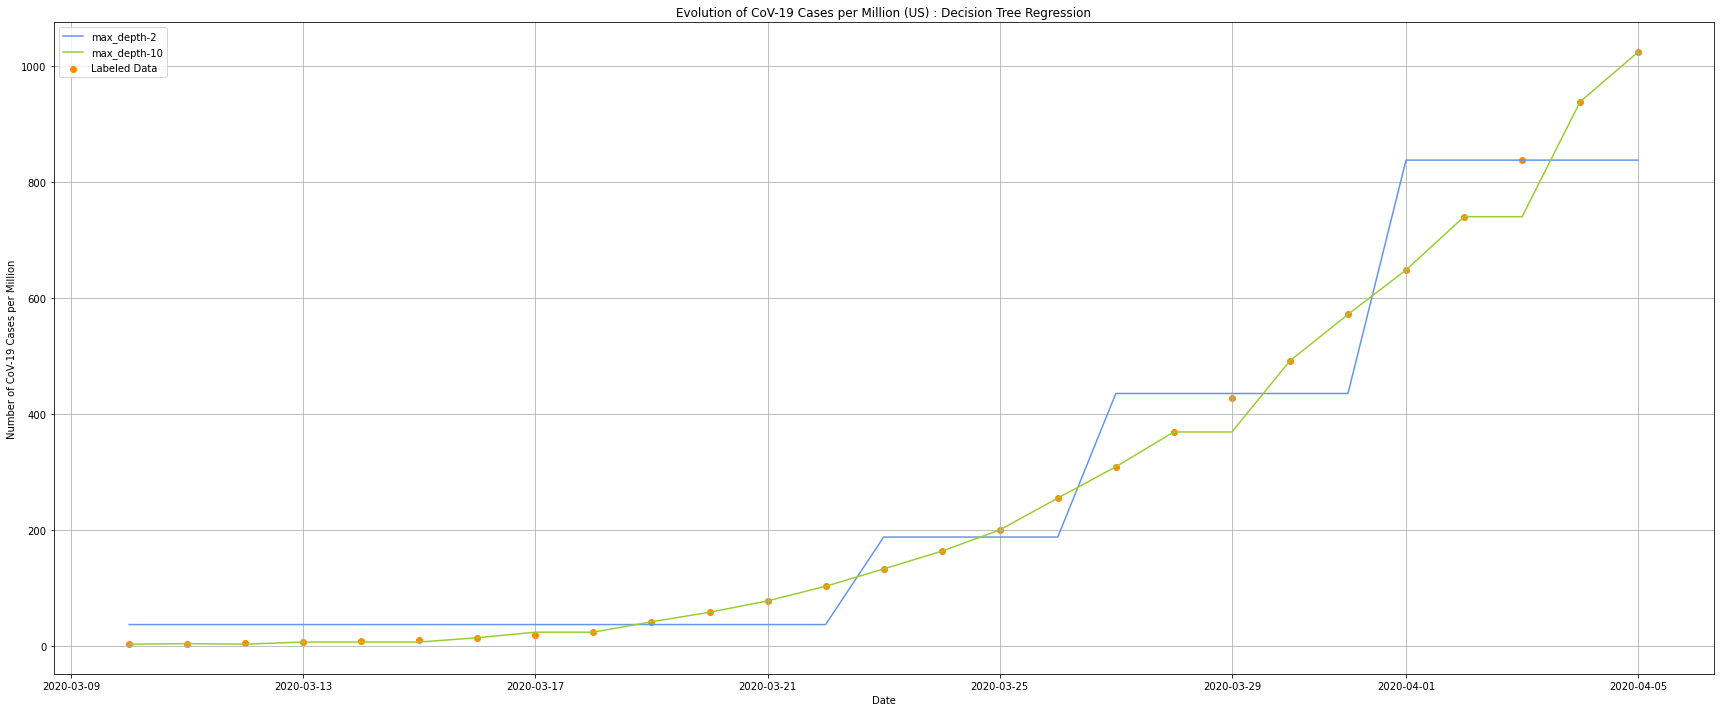

In [49]:
# Decision Tree Models
dt_regressor_2 = DecisionTreeRegressor(max_depth=2)
dt_regressor_10 = DecisionTreeRegressor(max_depth=10)

# Fitting/Training models
dt_regressor_2.fit(X_train, Y_train)
dt_regressor_10.fit(X_train, Y_train)

# Obtaining predictions from models
max_depth2_prediction = dt_regressor_2.predict(X)
max_depth10_prediction = dt_regressor_10.predict(X)

# Testing models
dt_regressor_2_score = dt_regressor_2.score(X_test,Y_test)
dt_regressor_10_score = dt_regressor_10.score(X_test,Y_test)

print("DT2", dt_regressor_2_score)
print("DT10", dt_regressor_10_score)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
max_depth2, = ax.plot(date_format[day_index:], max_depth2_prediction, color='cornflowerblue')
max_depth10, = ax.plot(date_format[day_index:], max_depth10_prediction, color='yellowgreen')
ax.legend((max_depth2, max_depth10, labeled), ('max_depth-2', 'max_depth-10','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Decision Tree Regression" % (country))
plt.tight_layout()
plt.show()

Fortunately, given that our data does not contain noise and was handled carefully beforehand, the use of a high *max_depth* parameter tends to be beneficial.

### Neural Network - Multi-layer Perceptron

Finally, we continue our study by using a Neural Network. For this, we are using a multi-layer perceptron which iteratively corrects its parameters according to the partial derivatives of the loss function.
The default solver *adam* works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, *lbfgs* can converge faster and perform better.

Score 0.963035649571465


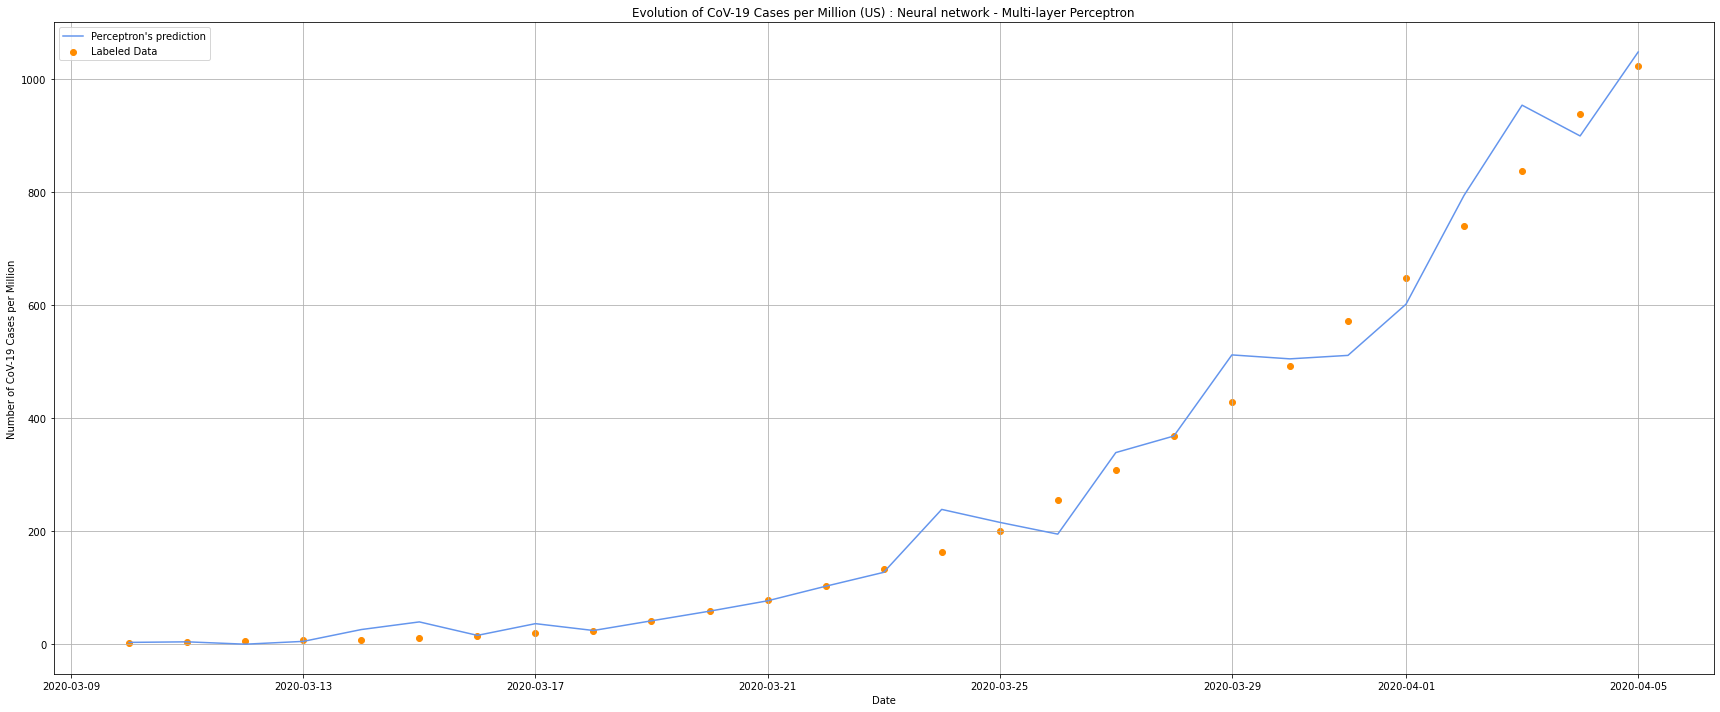

In [50]:
hidden_layers = 5
# Fitting/Training Neural Network (MLP) Model
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X_train, Y_train)

# Obtaining predictions from models
NN_predict = model.predict(X)

# Testing models
NN_score = model.score(X_test, Y_test)
print('Score', NN_score)

# Visual Comparison of the predictions obtained by the NN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
NN_plot, = ax.plot(date_format[day_index:], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Neural network - Multi-layer Perceptron" % (country))
plt.tight_layout()
plt.show()

Although it requires a lot of computational power, especially for such a small dataset, it provides good and consistent results.

To better visualize the differences, in terms of scores, between the several algorithms we can look at the graph below.

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

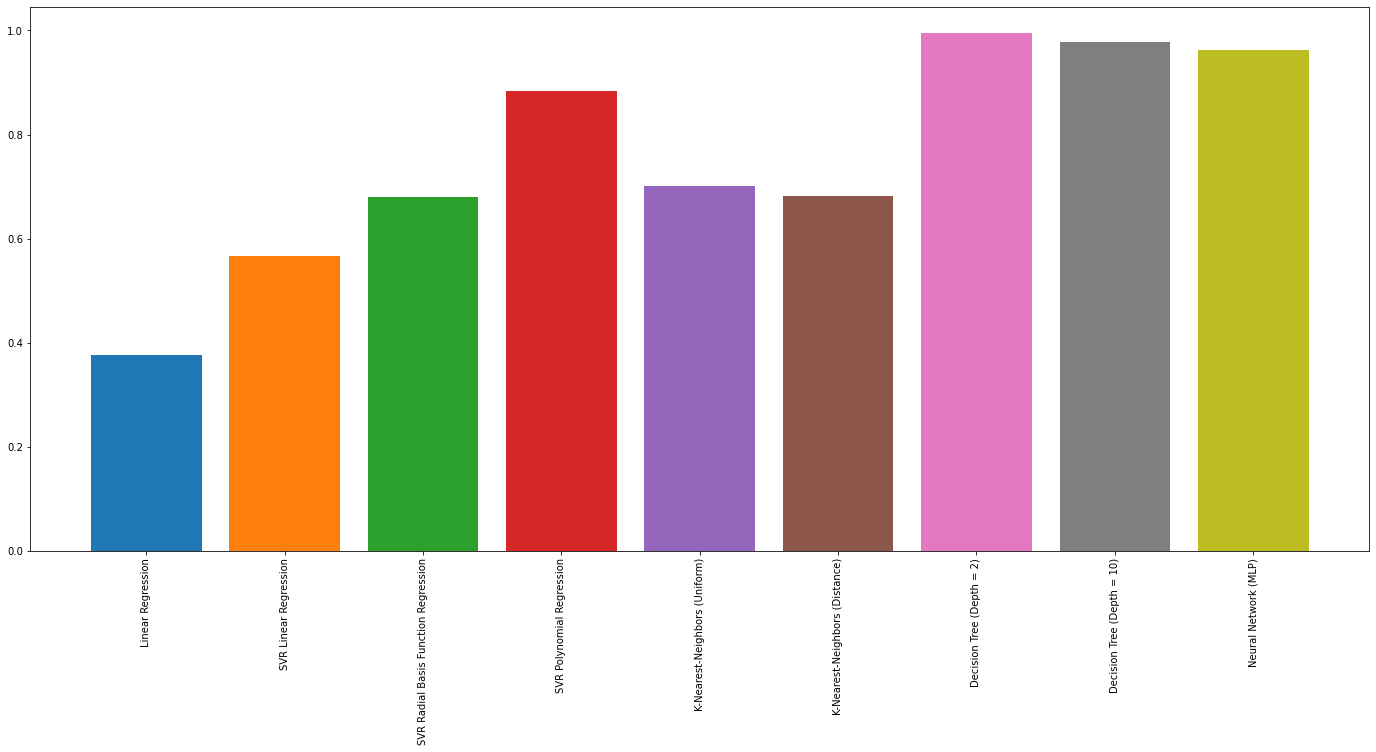

In [51]:
# Visual Comparison of the scores obtained by the different 
# models when predicting labeled data
_, ax = plt.subplots(figsize=(24, 10))
ax.bar('Linear Regression', linear_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Linear Regression', svr_lin_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Radial Basis Function Regression', svr_rbf_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Polynomial Regression', svr_poly_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('K-Nearest-Neighbors (Uniform)', knn_uniform_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('K-Nearest-Neighbors (Distance)', knn_distance_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Decision Tree (Depth = 2)', dt_regressor_2_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('Decision Tree (Depth = 10)', dt_regressor_10_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Neural Network (MLP)', NN_score, width=0.8, bottom=None, align='center', data=None)

plt.xticks(rotation=90)

### Principal Component Analysis

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of variables, possibly correlated, into a set of values ​​of variables not linearly correlated, the main components. The PCA must be applied to the training set to obtain a new coordinate system defined only by the proper vectors, which are statistically significant.


In [52]:
pca = PCA(0.95)
principalComponents = pca.fit_transform(X) 
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents) 
print(pca.components_)

[0.68247997 0.22296736 0.04696344]
[[ 0.39289409  0.37283452 -0.39404191  0.41568115  0.42553647  0.40800669
  -0.11841312  0.13037019]
 [ 0.13027736  0.07523198  0.0954432  -0.02519027 -0.02923957 -0.06659996
   0.69299011  0.69433292]
 [-0.1337239  -0.66305254 -0.54063077 -0.19280261 -0.00926701  0.43545896
   0.1354905   0.0704039 ]]


Using this analysis, we obtain the principal components that make up for at least 95% of the variance ratio. These are the **Transit Stations**, **Daily Percentage Change of the Total Number of Cases**, and **Parks**, respectively.

### Another Approach
---
Knowing that different countries apply different policies and have different lifestyles, we believe it would be interesting to see the evolution of the average total number of cases per million amongst the 19 countries included in the dataset.

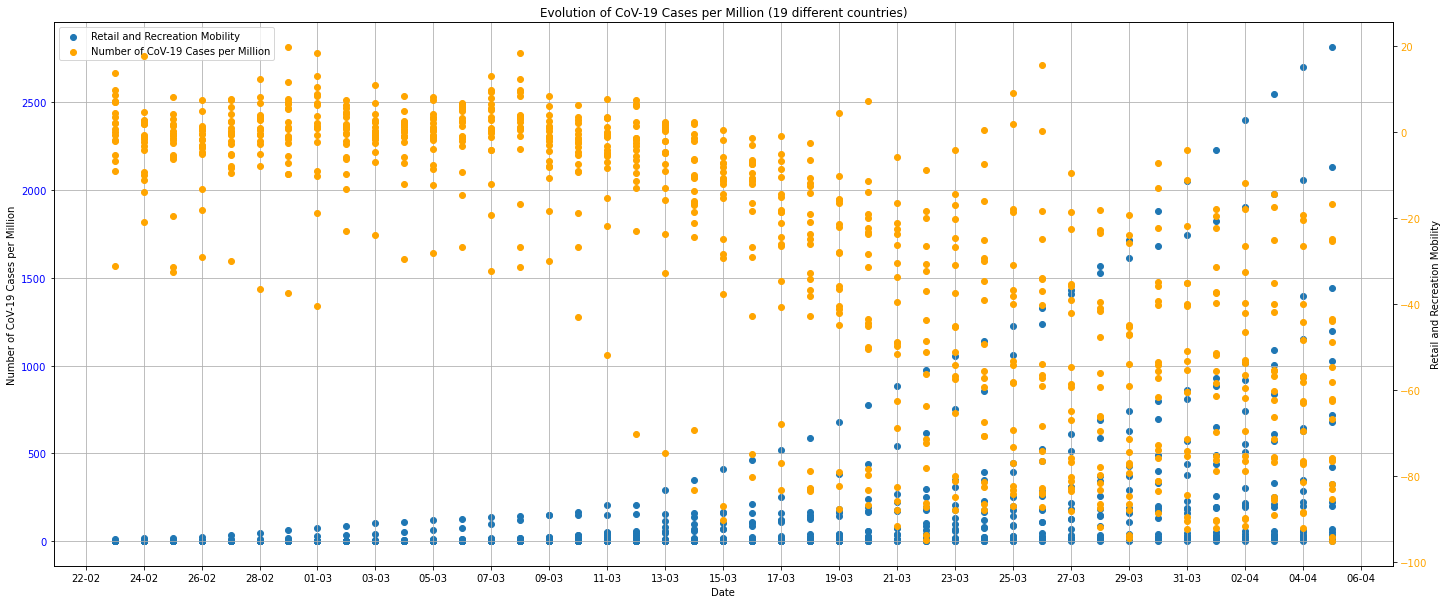

In [53]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')
data = data.drop(columns = ['country','iso'])

# Calculates daily percentual changes in number of fatalities
data['fatalities_percent_change'] = pd.Series([])
for i in range(0,len(data['fatalities'])):
    if i != 0 and data['fatalities'][i-1] != 0:
        data['fatalities_percent_change'][i]= (data['fatalities'][i] - data['fatalities'][i-1]) * 100 /data['fatalities'][i-1]
    else:data['fatalities_percent_change'][i] = 0

# Calculates daily percentual changes in number of cases
data['cases_percent_change'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if i != 0 and data['total_cases'][i-1] != 0:
        data['cases_percent_change'][i]= (data['total_cases'][i] - data['total_cases'][i-1]) * 100 /data['total_cases'][i-1]
    else:data['cases_percent_change'][i] = 0

# Calculates cases of covid per million inhabitants
data['cases_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

# Drop unnecessary columns from data set
data = data.drop(columns = ['fatalities'])
data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['population'])

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
cases_scatter1 = ax.scatter(date_format, data['cases_per_million'])
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title=("Evolution of CoV-19 Cases per Million (19 different countries)"))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelcolor= "blue")
ax2 = ax.twinx()  
ax2.set_ylabel('Retail and Recreation Mobility')
retail_scatter1 = ax2.scatter(date_format, data['retail_recreation'], color = "orange")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "orange")
ax.legend((cases_scatter1,retail_scatter1), ('Retail and Recreation Mobility', 'Number of CoV-19 Cases per Million'), loc='upper left', shadow=False)
plt.show()

As we can see, both the number of confirmed cases and the mobility change vary considerably according to the country they represent. To predict how the average total number of cases per million would evolve, we are using a Neural Network similar to the previous one.

Score 0.9489916731019538


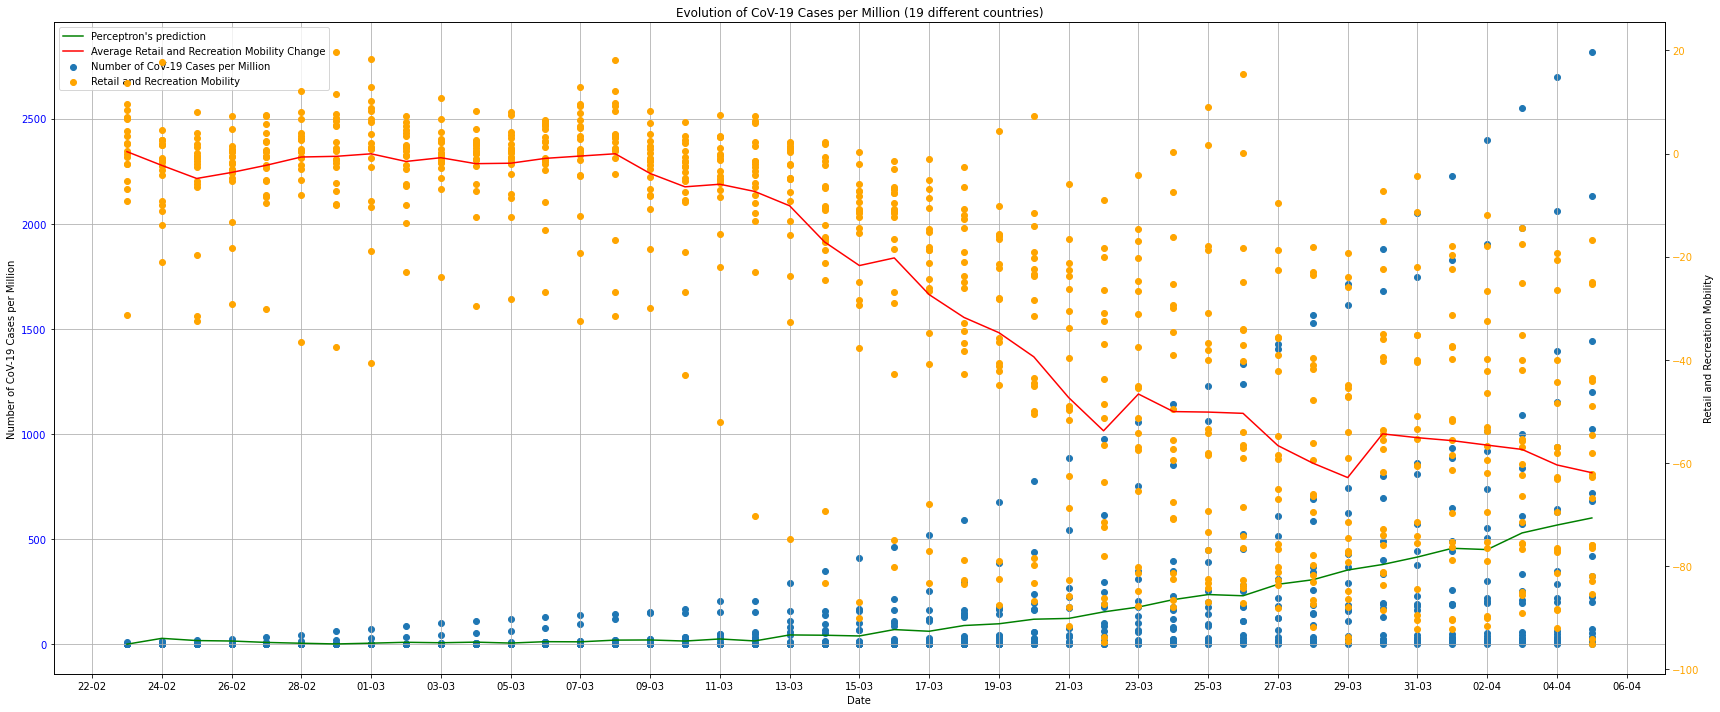

In [54]:
_, ax = plt.subplots(figsize=(24, 10))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
cases_scatter2 = ax.scatter(date_format, data['cases_per_million'])

ax2 = ax.twinx()  
ax2.set_ylabel('Retail and Recreation Mobility')
recreation_scatter2 = ax2.scatter(date_format, data['retail_recreation'], color = "orange")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "orange")

dates = data['date']
dates = dates[:43]
date_format = [pd.to_datetime(d) for d in dates]

data['date'] = data['date'].astype('datetime64')
data = data.groupby(data['date'].dt.date).mean()
x = data.iloc[:,1:8]
y = data.iloc[:,8:]

# Replaces NaN values present in the new columns by 0
x['fatalities_percent_change'] = x['fatalities_percent_change'].replace(np.NaN, 0)
x['cases_percent_change'] = x['cases_percent_change'].replace(np.NaN, 0)
y['cases_per_million'] = y['cases_per_million'].replace(np.NaN, 0)

# Fills the empty values taking mean values present in each column
x = x.replace("", np.NaN)
y = y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(x)
Y = imputer.fit_transform(y)

# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)

# Train/Test Split (80%/20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Initalization of the Neural Network Model 
hidden_layers = 5
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X_train, Y_train)

# Obtaining predictions from the model
NN_predict = model.predict(X)

# Testing the model
NN_score = model.score(X_test, Y_test)
print('Score', NN_score)

# Plot the results
ax.grid()
ax.set(xlabel="Date", ylabel='Number of CoV-19 Cases per Million', title=("Evolution of CoV-19 Cases per Million (19 different countries)"))
NN_plot, = ax.plot(date_format, NN_predict, color='green')
recreation_plot, = ax2.plot(date_format, data['retail_recreation'], color='red')
ax.legend((NN_plot,recreation_plot, cases_scatter2, recreation_scatter2), ('Perceptron\'s prediction', 'Average Retail and Recreation Mobility Change', 'Number of CoV-19 Cases per Million','Retail and Recreation Mobility'), loc='upper left', shadow=False)
ax.tick_params(axis='y', labelcolor= "blue")
plt.tight_layout()
plt.show()

The graph above displays how the average number of confirmed cases per million evolves and confirms the previous conclusions.


## Conclusion
This project helped us by introducing ourselves to Machine Learning, demystifying such a relevant branch of Artificial Intelligence.
We believe that given the circumstances, the subject of the project was crucial to demonstrate one of the many practical uses of this field making it more engaging.
One of the main obstacles we had to face was the small dimension of our input dataset, mainly because of how recently this issue has surfaced. This has made it harder to implement useful methods such as K-Fold Cross Validation making the results somewhat unstable. Despite the difficulties, all of the algorithms were successfully implemented delivered good results. 


## References & Acknowledgements
    Google Community Mobility Reports and COVID Incidence. Dataset used with detailed information about it. Available at: https://www.kaggle.com/gustavomodelli/covid-community-measures​

    Supervised Learning Documentation. Official scikit-learn documentation about regression. Available at: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning​

    Different ways to compensate for missing values. Available at: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779​
    
    List of countries and dependencies by population. Available at: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population